In [1]:
import torch
import ioc

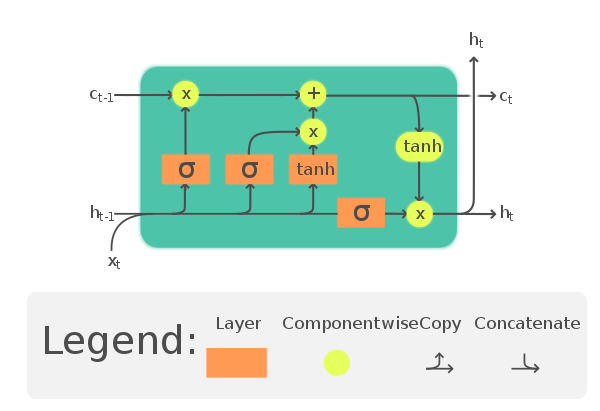

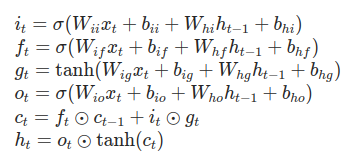

# Тесты моделей

In [ ]:
rnn = torch.nn.Linear(17, 11)
input_tensor = torch.randn(2, 2, )

In [2]:
rnn = torch.nn.LSTM(50, 20, 4)
input_tensor = torch.randn(5, 3, 50)
h0 = torch.randn(4, 3, 20)
c0 = torch.randn(4, 3, 20)
output, (hn, cn) = rnn(input_tensor, (h0, c0))
output.shape, hn.shape, cn.shape

(torch.Size([5, 3, 20]), torch.Size([4, 3, 20]), torch.Size([4, 3, 20]))

# Реализация ручками

In [ ]:
ioc.provide('LSTM.ActivationFunctions.Main', torch.nn.ReLU)
ioc.provide('LSTM.ActivationFunctions.Secondary', torch.nn.Tanh)
ioc.provide('LSTM.ActivationFunctions.CellHidenProd', torch.nn.Tanh)

In [ ]:
class MyLSTM(torch.nn.Module):
	def __init__(
		self, 
		input_data_length, 
		input_hiden_state_length, 
		input_cell_state_length
	):
		self.input_data_length = input_data_length
		self.input_hiden_state_length = input_hiden_state_length
		self.input_cell_state_length = input_cell_state_length
		
		self.input_layer_for_data_1 = torch.nn.Linear(in_features=self.input_data_length)
		self.input_layer_for_hidden_state_1 = torch.nn.Linear(in_features=self.input_hiden_state_length)
		self.input_layer_for_data_2 = torch.nn.Linear(in_features=self.input_data_length)
		self.input_layer_for_hidden_state_2 = torch.nn.Linear(in_features=self.input_hiden_state_length)
		self.input_layer_for_data_3 = torch.nn.Linear(in_features=self.input_data_length)
		self.input_layer_for_hidden_state_3 = torch.nn.Linear(in_features=self.input_hiden_state_length)
		self.input_layer_for_cell_state = torch.nn.Linear(in_features=self.input_cell_state_length)

		def forward(data, hidden_state, cell_state):
			i_t = ioc.require('LSTM.ActivationFunctions.Main')(
				self.input_layer_for_data_1(data) + self.input_layer_for_hidden_state_1(hidden_state)
			)
			f_t = ioc.require('LSTM.ActivationFunctions.Main')(
				self.input_layer_for_data_2(data) + self.input_layer_for_hidden_state_2(hidden_state)
			)
			o_t = ioc.require('LSTM.ActivationFunctions.Main')(
				self.input_layer_for_data_3(data) + self.input_layer_for_hidden_state_3(hidden_state)
			)
			g_t = ioc.require('LSTM.ActivationFunctions.Secondary')(
				self.input_layer_for_data_3(data) + self.input_layer_for_hidden_state_3(hidden_state)
			)


			new_cell_state = f_t @ cell_state + i_t @ g_t
			new_hidden_state = o_t @ ioc.require('LSTM.ActivationFunctions.CellHidenProd')(new_cell_state)
			return new_hidden_state.clone(), new_cell_state, new_hidden_state
			


# Реализация ручками (Shortcut)

In [6]:
ioc.provide('LSTM.ActivationFunctions.Main', torch.nn.ReLU)
ioc.provide('LSTM.ActivationFunctions.Secondary', torch.nn.Tanh)
ioc.provide('LSTM.ActivationFunctions.CellHidenProd', torch.nn.Tanh)

torch.nn.modules.activation.Tanh

In [ ]:
class MyLSTM(torch.nn.Module):
	def __init__(
		self, 
		input_data_length, 
		input_hiden_state_length, 
		input_cell_state_length
	):
		self.input_data_length = input_data_length
		self.input_hiden_state_length = input_hiden_state_length
		self.input_cell_state_length = input_cell_state_length
		
		self.input_layer_for_data = torch.nn.Linear(in_features=self.input_data_length)
		self.input_layer_for_hidden_state = torch.nn.Linear(in_features=self.input_hiden_state_length)
		self.input_layer_for_cell_state = torch.nn.Linear(in_features=self.input_cell_state_length)

		def forward(data, hidden_state, cell_state):
			summarization = self.input_layer_for_data(data) + self.input_layer_for_hidden_state(hidden_state)
			summarization_main = ioc.require('LSTM.ActivationFunctions.Main')(summarization)
			summarization_secondary = ioc.require('LSTM.ActivationFunctions.Secondary')(summarization)
			new_cell_state = summarization_main @ cell_state + summarization_main @ summarization_secondary
			new_hidden_state = summarization_main @ ioc.require('LSTM.ActivationFunctions.CellHidenProd')(new_cell_state)
			return new_hidden_state.clone(), new_cell_state, new_hidden_state
			
